
# P-571 — Apple Stock Forecast (2012–2019) → Predict Next 30 Days

**Business Objective**  
Predict Apple stock **Close** price for the **next 30 days** using historical **OHLC** data (2012–2019).  
We will:
- Perform **EDA** (trends, moving averages, volatility).
- Build an **LSTM** model for forecasting.
- Split **2019** as test set.
- Forecast **next 30 days** beyond the last available date.
- Export results to CSV and provide a simple deployable app snippet.

> Dataset: `AAPL.csv` (columns like: Date, Open, High, Low, Close, Volume)


In [1]:

# === Imports ===
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Optional: Deep learning (TensorFlow/Keras). If missing, install manually in your environment.
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
except Exception as e:
    print("TensorFlow not available in this environment. Please install it locally:")
    print("pip install tensorflow==2.15.*  # or compatible version")
    tf = None

# Plot settings
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)


Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
NumPy: 1.26.4
Pandas: 2.2.3


In [2]:

# === Load Data ===
# If running in this notebook environment with the uploaded file:
csv_path = "AAPL.csv"  # Place AAPL.csv in the same folder as this notebook
if not os.path.exists(csv_path):
    # Fallback for environments like ChatGPT where file may be in a mounted path
    alt = "/mnt/data/AAPL.csv"
    if os.path.exists(alt):
        csv_path = alt

df = pd.read_csv(csv_path)

# Normalize column names
df.columns = [c.strip().title() for c in df.columns]
if 'Date' not in df.columns:
    raise ValueError("Expected a 'Date' column in AAPL.csv")

# Parse dates and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(df.head())
print(df.tail())
print(df.describe(include='all'))


        Date       Open       High        Low      Close  Adj Close    Volume
0 2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
1 2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2 2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
3 2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
4 2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100
           Date        Open        High         Low       Close   Adj Close  \
2006 2019-12-23  280.529999  284.250000  280.369995  284.000000  282.054138   
2007 2019-12-24  284.690002  284.890015  282.920013  284.269989  282.322266   
2008 2019-12-26  284.820007  289.980011  284.700012  289.910004  287.923645   
2009 2019-12-27  291.119995  293.970001  288.119995  289.799988  287.814392   
2010 2019-12-30  289.459991  292.690002  285.220001  291.519989  289.522614   

        Volume  
2006  24643000  
2007  12119700  
2008  

## Exploratory Data Analysis (EDA)

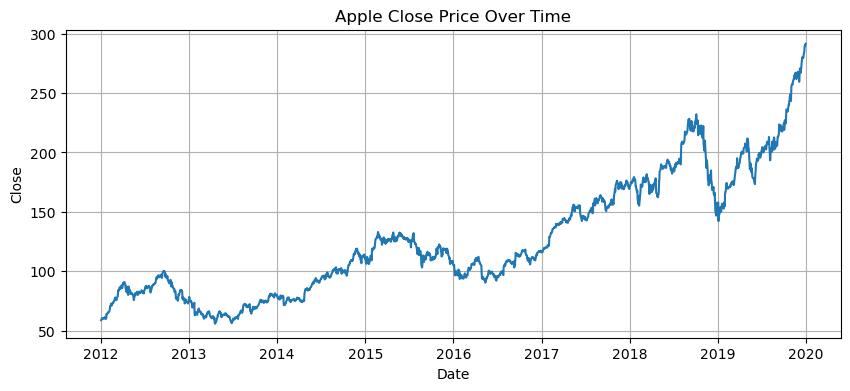

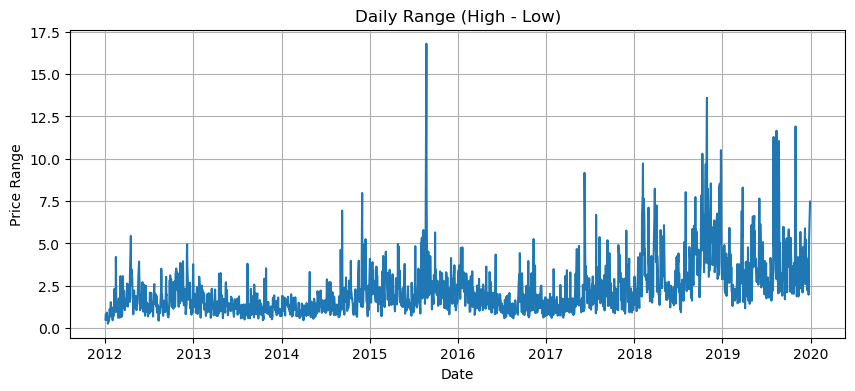

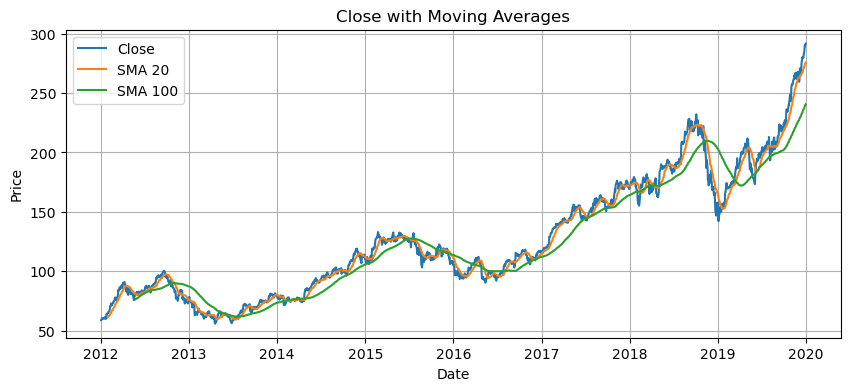

In [3]:

# Close price over time
plt.figure()
plt.plot(df['Date'], df['Close'])
plt.title("Apple Close Price Over Time")
plt.xlabel("Date"); plt.ylabel("Close")
plt.show()

# High-Low (daily range) as proxy for volatility
daily_range = df['High'] - df['Low']
plt.figure()
plt.plot(df['Date'], daily_range)
plt.title("Daily Range (High - Low)")
plt.xlabel("Date"); plt.ylabel("Price Range")
plt.show()

# Moving averages (short vs long term)
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_100'] = df['Close'].rolling(window=100).mean()

plt.figure()
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['SMA_20'], label='SMA 20')
plt.plot(df['Date'], df['SMA_100'], label='SMA 100')
plt.title("Close with Moving Averages")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend()
plt.show()


## Train / Test Split (2019 as Test)

In [4]:

# Use 2019 as test set as per requirement
train_df = df[df['Date'] < '2019-01-01'].copy()
test_df  = df[(df['Date'] >= '2019-01-01') & (df['Date'] <= df['Date'].max())].copy()

print("Train start/end:", train_df['Date'].min(), train_df['Date'].max(), "rows:", len(train_df))
print("Test  start/end:", test_df['Date'].min(), test_df['Date'].max(), "rows:", len(test_df))

# We'll predict 'Close' with an LSTM on sequences of past closes
close_values = df[['Date','Close']].copy()


Train start/end: 2012-01-03 00:00:00 2018-12-31 00:00:00 rows: 1760
Test  start/end: 2019-01-02 00:00:00 2019-12-30 00:00:00 rows: 251


## Prepare Sequences for LSTM

In [5]:

# Scale using only training portion to avoid leakage
scaler = MinMaxScaler(feature_range=(0, 1))
close_train = train_df[['Close']].values
close_test  = test_df[['Close']].values

scaler = scaler.fit(close_train)
train_scaled = scaler.transform(close_train)
test_scaled  = scaler.transform(close_test)

def make_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X = np.array(X); y = np.array(y)
    # Reshape for LSTM: [samples, timesteps, features=1]
    return X.reshape((X.shape[0], X.shape[1], 1)), y

LOOKBACK = 60
X_train, y_train = make_sequences(train_scaled, lookback=LOOKBACK)
X_test,  y_test  = make_sequences(np.vstack([train_scaled[-LOOKBACK:], test_scaled]), lookback=LOOKBACK)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (1700, 60, 1) y_train: (1700,)
X_test : (251, 60, 1) y_test : (251,)


## Build & Train LSTM

Epoch 1/15


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0500 - val_loss: 0.0042
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017 - val_loss: 0.0082
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 9/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 10/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 11/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 12/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_l

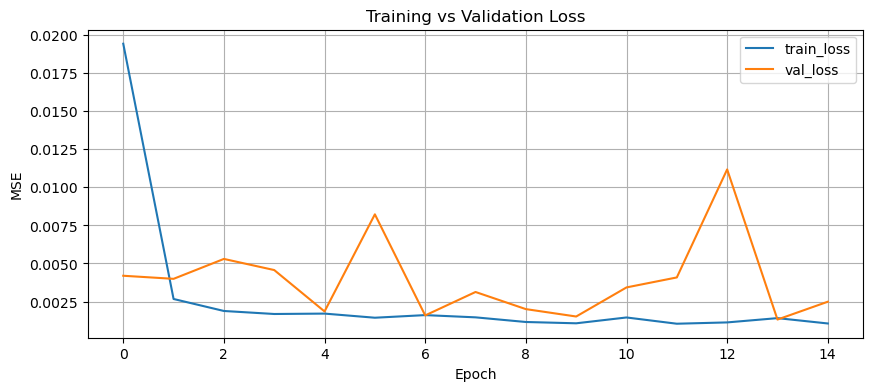

In [6]:

if tf is None:
    print("TensorFlow missing. Skip training here, but code is ready for local run.")
else:
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(LOOKBACK, 1)),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=15,
        batch_size=32,
        verbose=1
    )

    # Plot training loss
    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE")
    plt.legend()
    plt.show()


## Evaluate on 2019 Test Set

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE : 7.388
RMSE: 8.798
MAPE: 3.44%


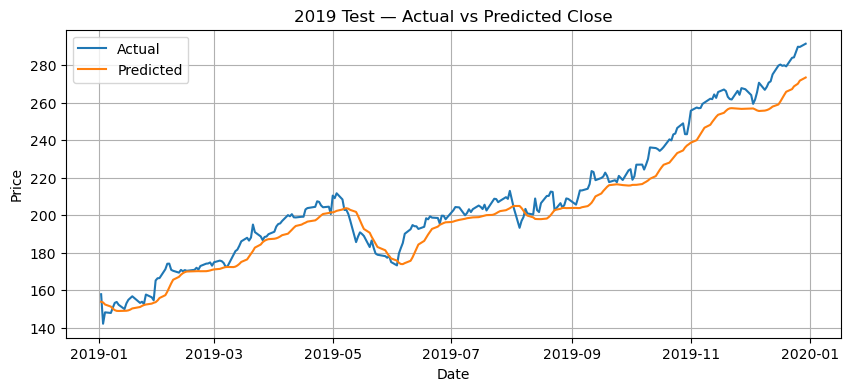

In [7]:

if tf is None:
    print("TensorFlow missing—cannot evaluate here. Run locally after installing TF.")
else:
    # Predictions (scaled -> inverse transform)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test.reshape(-1,1))

    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"MAE : {mae:,.3f}")
    print(f"RMSE: {rmse:,.3f}")
    print(f"MAPE: {mape:,.2f}%")

    # Align predictions with test dates (skip first LOOKBACK days from combined sequence)
    test_dates = test_df['Date'].values
    pred_start_idx = 0  # after we built X_test from tail of train + test, first y_test aligns with first test day
    aligned_dates = test_df['Date'][pred_start_idx + 0 : pred_start_idx + len(y_pred)].values

    plt.figure()
    plt.plot(test_df['Date'], test_df['Close'], label='Actual')
    plt.plot(aligned_dates, y_pred.flatten(), label='Predicted')
    plt.title("2019 Test — Actual vs Predicted Close")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend()
    plt.show()


## Forecast Next 30 Days (Recursive)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

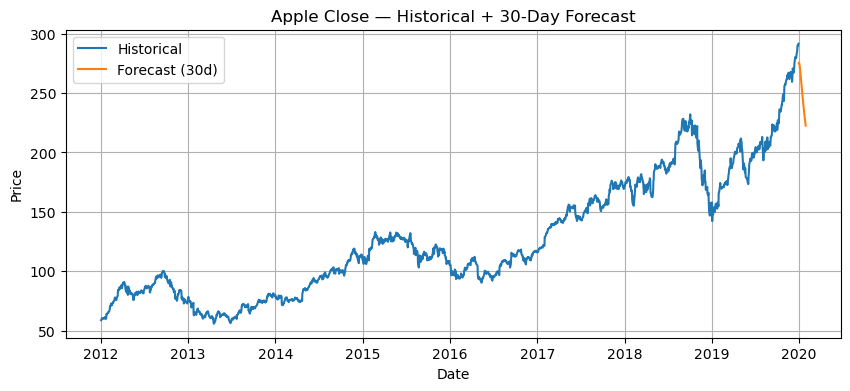

In [8]:

from datetime import timedelta

if tf is None:
    print("TensorFlow missing—cannot forecast here. Run locally after installing TF.")
else:
    # Start with last LOOKBACK closes from the full series
    full_close = df['Close'].values.reshape(-1,1)
    last_seq = scaler.transform(full_close[-LOOKBACK:])

    preds_scaled = []
    seq = last_seq.copy()

    for _ in range(30):
        p = model.predict(seq.reshape(1, LOOKBACK, 1))
        preds_scaled.append(p[0,0])
        # slide window
        seq = np.vstack([seq[1:], p])

    preds_scaled = np.array(preds_scaled).reshape(-1,1)
    preds = scaler.inverse_transform(preds_scaled).flatten()

    # Build future date index (next 30 calendar days; skip weekends filtering for simplicity)
    last_date = df['Date'].max()
    future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]

    forecast_df = pd.DataFrame({
        'date': future_dates,
        'forecast_close': preds
    })

    print(forecast_df.head())
    forecast_csv = "apple_30day_forecast.csv"
    forecast_df.to_csv(forecast_csv, index=False)
    print("Saved forecast to:", forecast_csv)

    # Plot
    plt.figure()
    plt.plot(df['Date'], df['Close'], label='Historical')
    plt.plot(forecast_df['date'], forecast_df['forecast_close'], label='Forecast (30d)')
    plt.title("Apple Close — Historical + 30-Day Forecast")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend()
    plt.show()



## (Optional) External Events Analysis

You can enrich the model/EDA with **external events** like:
- Product launches, earnings announcements
- Macro events (Fed decisions, COVID headlines, etc.)

**How to use:** Create a CSV `events.csv` with columns: `date,event,severity` and then join on date for overlays/categorical regressors.


## Deployment Snippet (Streamlit)

In [9]:

# Save this as streamlit_app.py and run: streamlit run streamlit_app.py
streamlit_code = r'''
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

st.title("Apple Stock Forecast — 30 Days")

uploaded = st.file_uploader("Upload CSV with Date & Close columns", type=["csv"])
lookback = st.number_input("Lookback window", min_value=10, max_value=200, value=60, step=5)
epochs = st.number_input("Epochs", min_value=1, max_value=200, value=10, step=1)

if uploaded:
    df = pd.read_csv(uploaded)
    df.columns = [c.strip().title() for c in df.columns]
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    st.line_chart(df.set_index('Date')['Close'])

    # Train simple LSTM
    scaler = MinMaxScaler((0,1))
    data = scaler.fit_transform(df[['Close']].values)

    def make_seq(data, n):
        X,y = [],[]
        for i in range(n, len(data)):
            X.append(data[i-n:i,0])
            y.append(data[i,0])
        X = np.array(X).reshape(-1,n,1)
        y = np.array(y)
        return X,y

    X,y = make_seq(data, lookback)
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback,1)),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X,y,epochs=epochs,batch_size=32,verbose=0)

    # Forecast next 30
    seq = data[-lookback:].copy()
    preds = []
    for _ in range(30):
        p = model.predict(seq.reshape(1,lookback,1), verbose=0)[0,0]
        preds.append(p)
        seq = np.vstack([seq[1:], [p]])

    preds = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

    future_dates = pd.date_range(df['Date'].max()+pd.Timedelta(days=1), periods=30)
    out = pd.DataFrame({"date": future_dates, "forecast_close": preds})

    st.line_chart(out.set_index('date'))
    st.download_button("Download Forecast CSV", out.to_csv(index=False), file_name="forecast_30d.csv")
'''
with open("streamlit_app.py", "w") as f:
    f.write(streamlit_code)

print("Saved Streamlit app to streamlit_app.py")


Saved Streamlit app to streamlit_app.py
